In [1]:
import sklearnex
sklearnex.patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# ALL IMPORTS
import os
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

2023-08-07 01:56:42.120473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
# Choose one of the ways to import data below.

# My local path
df = pd.read_csv('/Users/pratik/Github/MScDataScienceThesis/Skyserver_SQL5_24_2023 12_41_33 PM.csv')

# Global Path
# df = pd.read_csv("https://raw.githubusercontent.com/iamstarstuff/MScDataScienceThesis/main/Skyserver_SQL5_24_2023%2

In [5]:
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

In [6]:
# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [7]:
def split_data(X, y, train_size=0.6, test_size=0.2, validation_size=0.2, random_state=None):
    # Split data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Calculate the percentage for validation data based on the remaining data after test split
    remaining_size = 1.0 - test_size
    val_size = validation_size / remaining_size

    # Split train+val data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [8]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y)

In [9]:
labels = df['class'].unique()
labels

array(['STAR', 'QSO', 'GALAXY'], dtype=object)

In [32]:
def plot_heatmap(matrix, title, labels):
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)
    
def plot_confusion_matrix(y_true, y_pred, labels):
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3),dpi=200)
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

def reporter(clf, X, y, title, labels, best=None):
    pred = clf.predict_proba(X=X)
    
    lgloss = log_loss(y_true=y, y_pred=pred)
    lgloss = np.round(a=lgloss, decimals=3)
    
    cm_pred = clf.predict(X=X)
    
    print(title)
    if best is None:
        print("Logloss: {}".format(lgloss))
    else:
        print("Logloss: {}".format(lgloss))
        print("Best parameters: {}".format(best))
    
    plot_confusion_matrix(y_true=y, y_pred=cm_pred, labels=labels)
    
    print(classification_report(y_true=y, y_pred=cm_pred))
    
    return lgloss

# Random Forest

In [11]:
rfc = RandomForestClassifier(random_state=random_seed)

## Baseline
Performance of classifier using the default hyperparameter values

In [13]:
rfc.fit(X_train,y_train)

y_test_pred = rfc.predict(X_test)
y_valid_pred = rfc.predict(X_val)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
validation_accuracy = accuracy_score(y_val, y_valid_pred)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.99145
Validation set Accuracy: 0.99113


Train
Logloss: 0.009
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


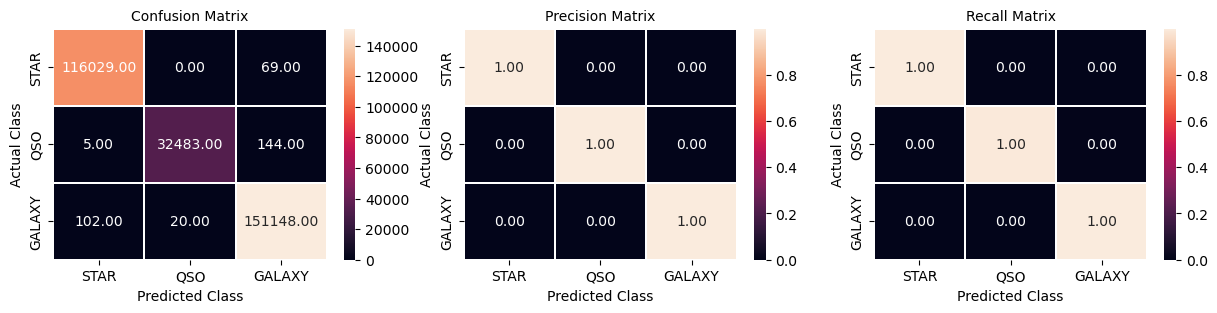

              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00    151270
         QSO       1.00      1.00      1.00     32632
        STAR       1.00      1.00      1.00    116098

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

Test
Logloss: 0.05
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


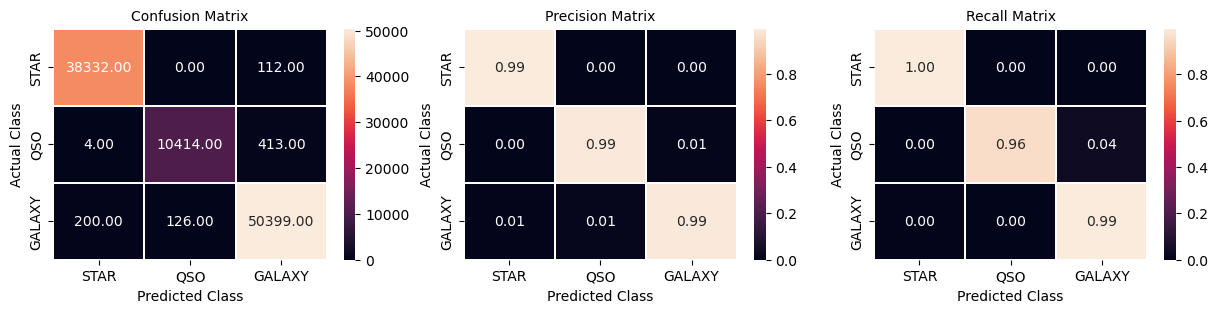

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50725
         QSO       0.99      0.96      0.97     10831
        STAR       0.99      1.00      1.00     38444

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.99    100000
weighted avg       0.99      0.99      0.99    100000

Validation
Logloss: 0.051
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


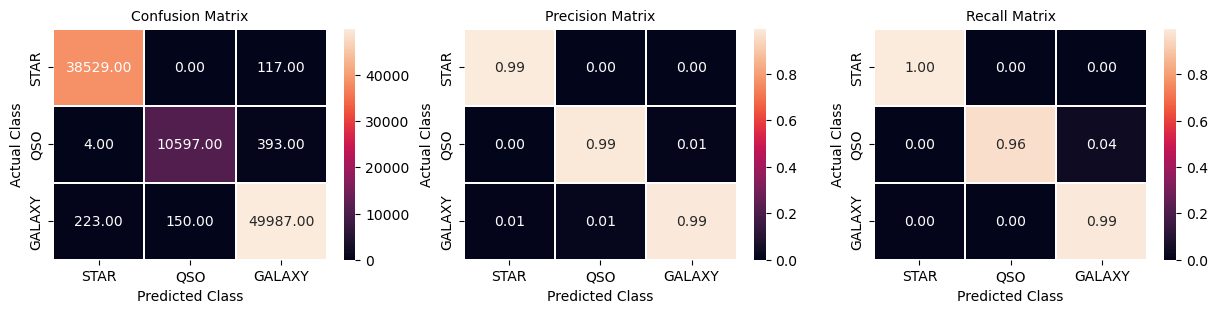

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50360
         QSO       0.99      0.96      0.97     10994
        STAR       0.99      1.00      1.00     38646

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.99    100000
weighted avg       0.99      0.99      0.99    100000



In [14]:
training_loss_rfc = reporter(clf=rfc, X=X_train, y=y_train, title='Train', labels=labels)
test_loss_rfc = reporter(clf=rfc, X=X_test, y=y_test, title='Test', labels=labels)
val_loss_rfc = reporter(clf=rfc, X=X_val, y=y_val, title='Validation', labels=labels)

## Genetic optimisation

In [15]:

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform',
                                                     random_state=random_seed),
              'n_estimators': Integer(100, 300,random_state=random_seed)}

# Write about why we use StratifiedKFold
# https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

rfc_genopt = GASearchCV(estimator=rfc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=5,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)
# TAKES ABOUT 15-20 MINUTES TO RUN
rfc_genopt.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.947509	0.0487177  	0.97494    	0.823433   
1  	12    	0.972395	0.00216501 	0.97494    	0.968843   
2  	9     	0.973929	0.00182915 	0.97494    	0.9692     
3  	13    	0.975158	0.000653   	0.977117   	0.97494    
4  	13    	0.975744	0.000683351	0.977117   	0.97494    
5  	14    	0.976382	0.00048117 	0.977117   	0.976067   


GASearchCV(crossover_probability=0.5,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           estimator=RandomForestClassifier(min_weight_fraction_leaf=0.014454547118247537,
                                            n_estimators=255, random_state=42),
           generations=5, keep_top_k=3, mutation_probability=0.1, n_jobs=-1,
           param_grid={'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x184421c90>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x1858d9b10>},
           population_size=10, return_train_score=True, scoring='accuracy')

Train
Logloss: 0.101
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


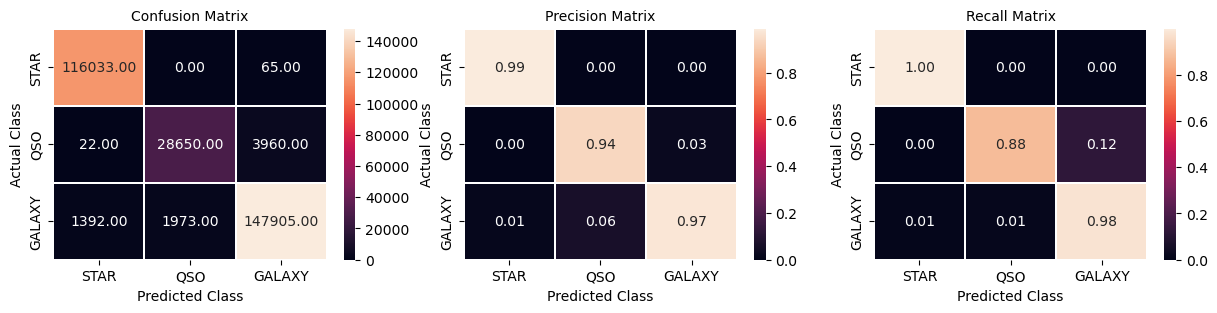

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98    151270
         QSO       0.94      0.88      0.91     32632
        STAR       0.99      1.00      0.99    116098

    accuracy                           0.98    300000
   macro avg       0.97      0.95      0.96    300000
weighted avg       0.97      0.98      0.98    300000

Test
Logloss: 0.102
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


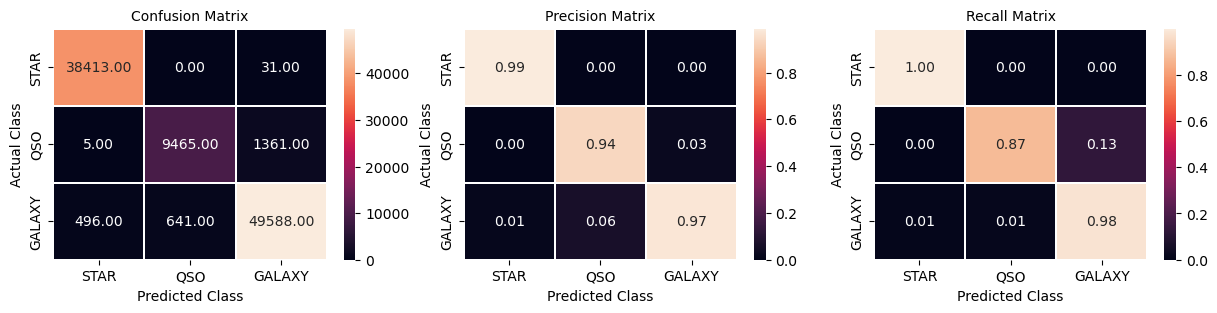

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     50725
         QSO       0.94      0.87      0.90     10831
        STAR       0.99      1.00      0.99     38444

    accuracy                           0.97    100000
   macro avg       0.97      0.95      0.96    100000
weighted avg       0.97      0.97      0.97    100000

Validation
Logloss: 0.102
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


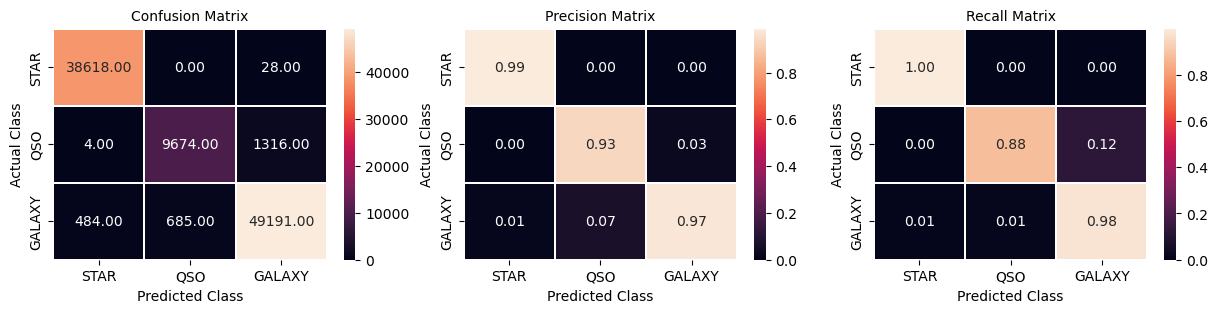

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     50360
         QSO       0.93      0.88      0.91     10994
        STAR       0.99      1.00      0.99     38646

    accuracy                           0.97    100000
   macro avg       0.96      0.95      0.96    100000
weighted avg       0.97      0.97      0.97    100000



In [16]:
training_loss_rfc_genopt = reporter(clf=rfc_genopt, X=X_train, y=y_train, title='Train', labels=labels)
test_loss_rfc_genopt = reporter(clf=rfc_genopt, X=X_test, y=y_test, title='Test', labels=labels)
val_loss_rfc_genopt = reporter(clf=rfc_genopt, X=X_val, y=y_val, title='Validation', labels=labels)

In [17]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(rfc_genopt.hof)

,0,1,2
min_weight_fraction_leaf,0.014455,0.014455,0.014455
n_estimators,255.000000,257.000000,125.000000


# Gradient Boosting Classifier

## Baseline

In [18]:
gbc = GradientBoostingClassifier(random_state=random_seed)

In [20]:
# TAKES 5 MINUTES TO RUN
gbc.fit(X_train, y_train)

y_test_pred = gbc.predict(X_test)
y_valid_pred = gbc.predict(X_val)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
validation_accuracy = accuracy_score(y_val, y_valid_pred)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.98763
Validation set Accuracy: 0.98731


Train
Logloss: 0.051
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


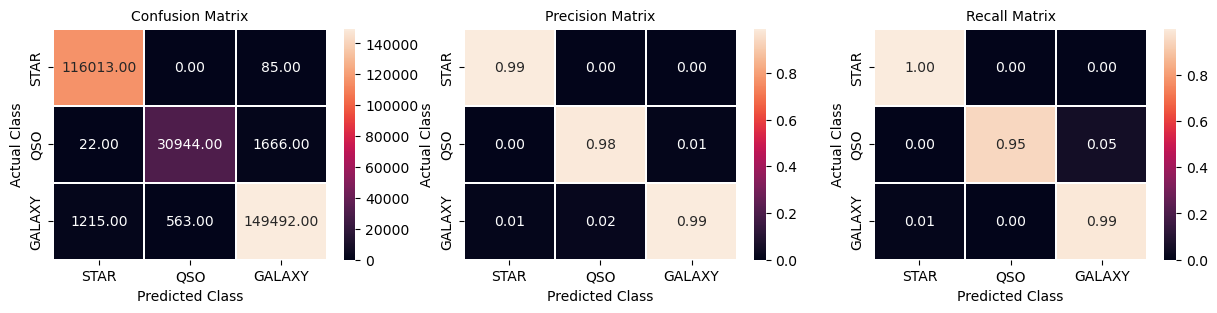

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99    151270
         QSO       0.98      0.95      0.96     32632
        STAR       0.99      1.00      0.99    116098

    accuracy                           0.99    300000
   macro avg       0.99      0.98      0.98    300000
weighted avg       0.99      0.99      0.99    300000

Test
Logloss: 0.053
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


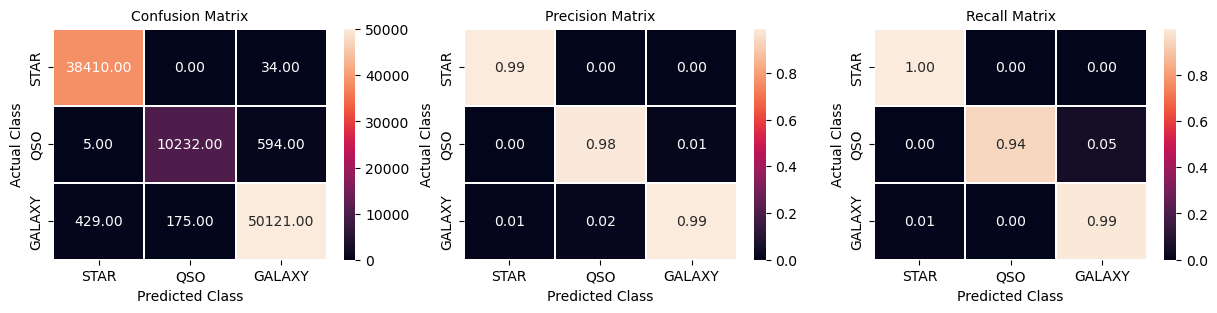

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50725
         QSO       0.98      0.94      0.96     10831
        STAR       0.99      1.00      0.99     38444

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000

Validation
Logloss: 0.053
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


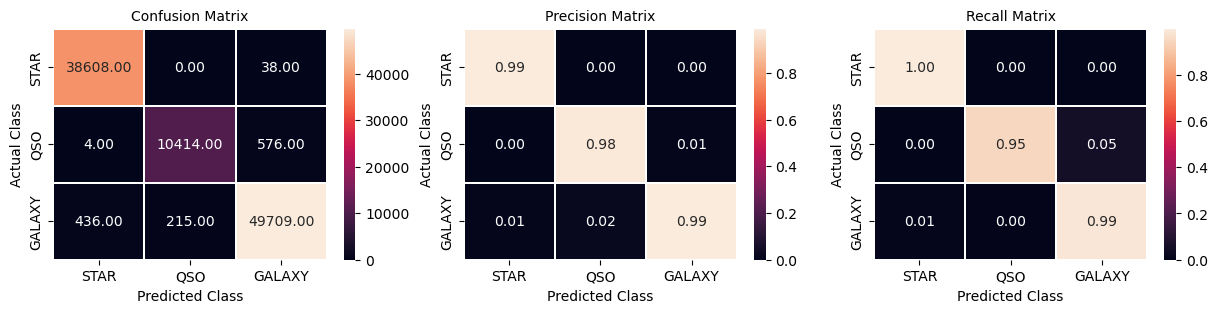

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50360
         QSO       0.98      0.95      0.96     10994
        STAR       0.99      1.00      0.99     38646

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000



In [21]:
training_loss_gbc = reporter(clf=gbc, X=X_train, y=y_train, title='Train', labels=labels)
test_loss_gbc = reporter(clf=gbc, X=X_test, y=y_test, title='Test', labels=labels)
val_loss_gbc = reporter(clf=gbc, X=X_val, y=y_val, title='Validation', labels=labels)

## Genetic Optimisation

In [22]:
gbc = GradientBoostingClassifier(random_state=random_seed)

param_grid = {
    'learning_rate': Categorical([0.0001, 0.001, 0.01, 0.1],random_state=random_seed),
    'n_estimators': Integer(50, 200, distribution='uniform',random_state=random_seed)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

gbc_genopt = GASearchCV(estimator=gbc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=5,
                               generations=5,
                               tournament_size=2,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [23]:
gbc_genopt.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.850162	0.178689   	0.98788    	0.504233   
1  	5     	0.967104	0.0403195  	0.98788    	0.886483   
2  	6     	0.987343	0.000877902	0.98788    	0.985597   
3  	4     	0.98777 	0.000111355	0.98793    	0.98768    
4  	5     	0.98776 	9.79796e-05	0.98788    	0.98768    
5  	7     	0.98784 	8e-05      	0.98788    	0.98768    


GASearchCV(crossover_probability=0.5,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           estimator=GradientBoostingClassifier(n_estimators=179,
                                                random_state=42),
           generations=5, keep_top_k=3, mutation_probability=0.1, n_jobs=-1,
           param_grid={'learning_rate': <sklearn_genetic.space.space.Categorical object at 0x1859fb5d0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x1853c5a10>},
           population_size=5, return_train_score=True, scoring='accuracy',
           tournament_size=2)

Train
Logloss: 0.047
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


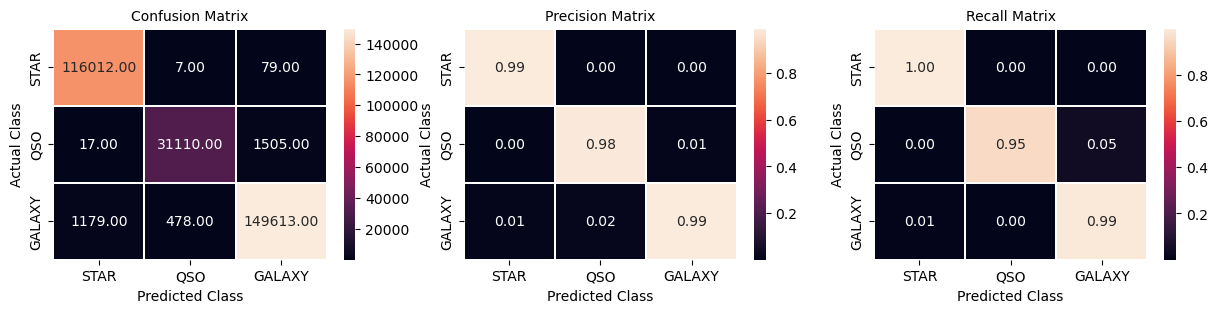

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99    151270
         QSO       0.98      0.95      0.97     32632
        STAR       0.99      1.00      0.99    116098

    accuracy                           0.99    300000
   macro avg       0.99      0.98      0.98    300000
weighted avg       0.99      0.99      0.99    300000

Test
Logloss: 0.052
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


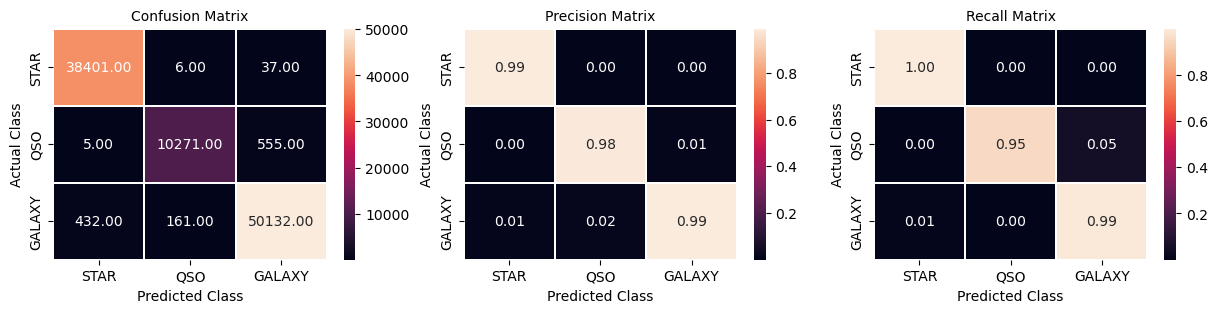

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50725
         QSO       0.98      0.95      0.97     10831
        STAR       0.99      1.00      0.99     38444

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000

Validation
Logloss: 0.052
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


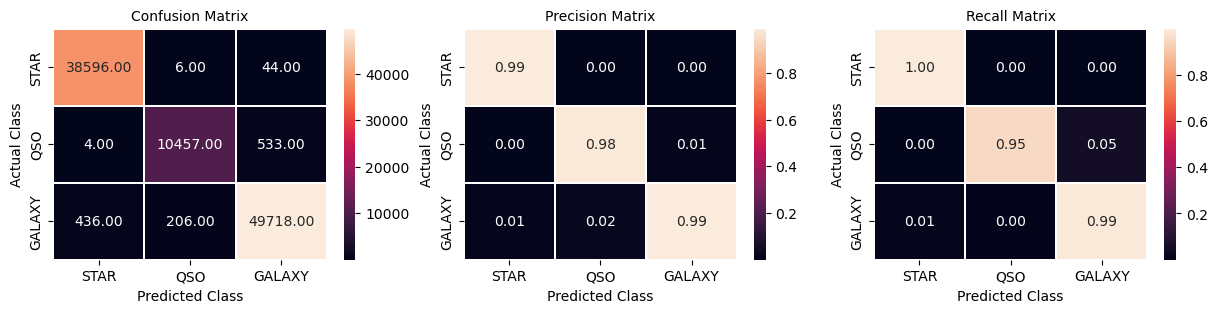

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     50360
         QSO       0.98      0.95      0.97     10994
        STAR       0.99      1.00      0.99     38646

    accuracy                           0.99    100000
   macro avg       0.99      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000



In [24]:
training_loss_gbc_genopt = reporter(clf=gbc_genopt, X=X_train, y=y_train, title='Train', labels=labels)
test_loss_gbc_genopt = reporter(clf=gbc_genopt, X=X_test, y=y_test, title='Test', labels=labels)
val_loss_gbc_genopt = reporter(clf=gbc_genopt, X=X_val, y=y_val, title='Validation', labels=labels)

In [25]:
pd.DataFrame(gbc_genopt.hof)

,0,1,2
learning_rate,0.1,0.1,0.1
n_estimators,179.0,166.0,155.0


# Logistic Regression

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
clf = LogisticRegressionCV(Cs=10, cv=cv, penalty='l2',solver='saga',n_jobs=-1,random_state=random_seed)
clf.fit(X=X_train, y=y_train)

/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     n_jobs=-1, random_state=42, solver='saga')

Train
Logloss: 0.075
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


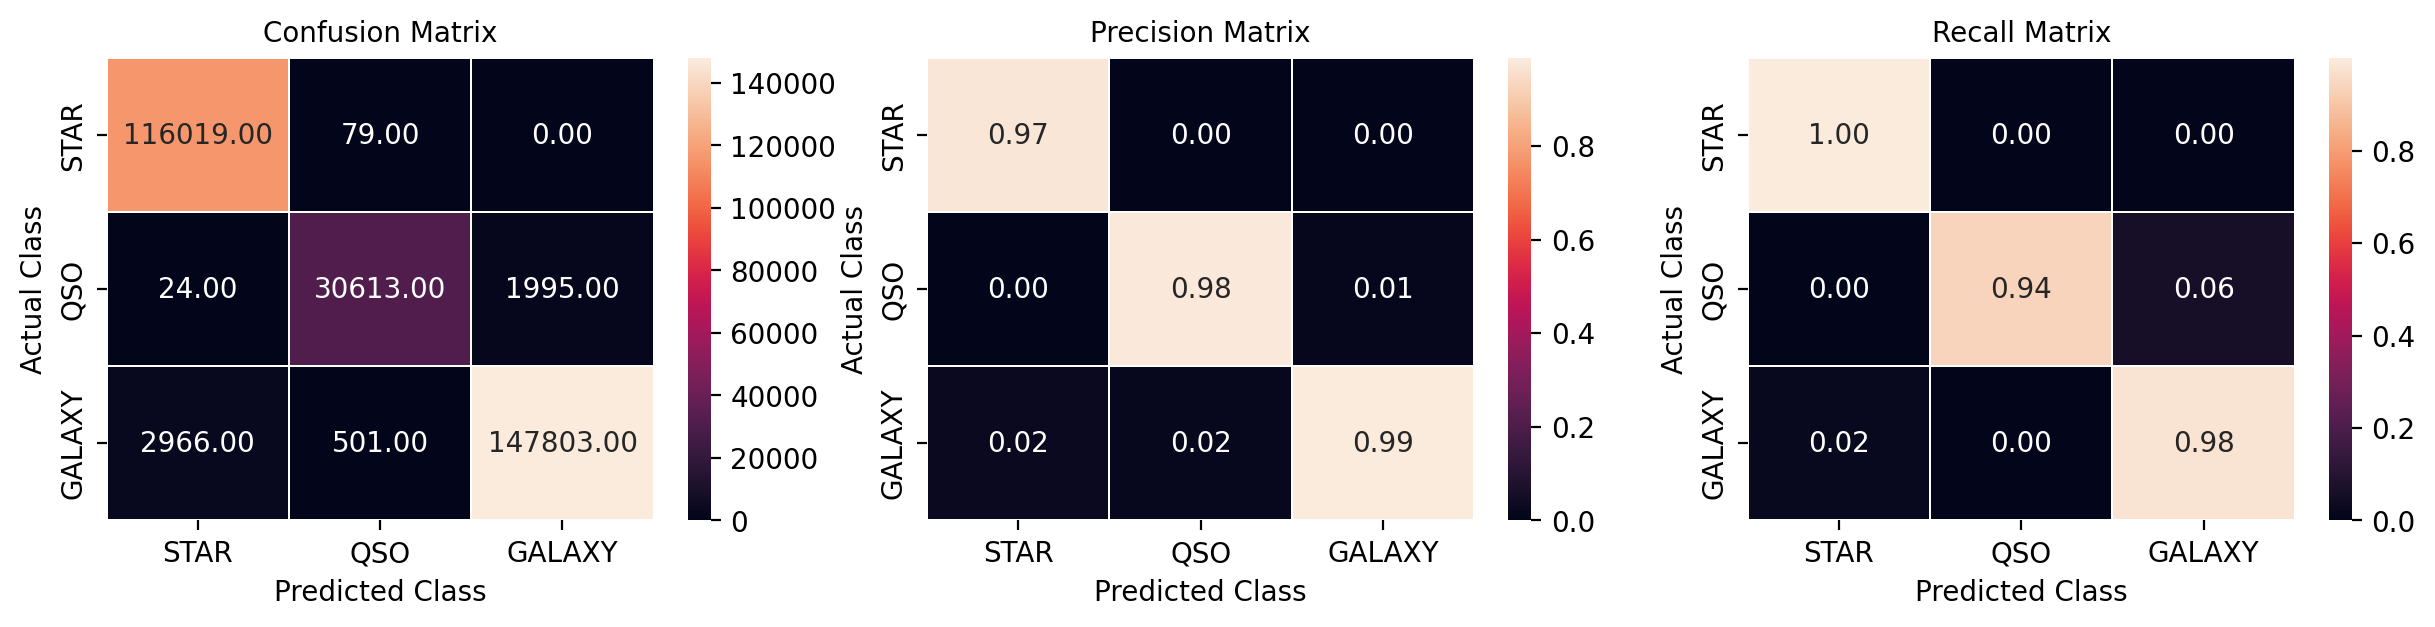

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98    151270
         QSO       0.98      0.94      0.96     32632
        STAR       0.97      1.00      0.99    116098

    accuracy                           0.98    300000
   macro avg       0.98      0.97      0.98    300000
weighted avg       0.98      0.98      0.98    300000

Test
Logloss: 0.074
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


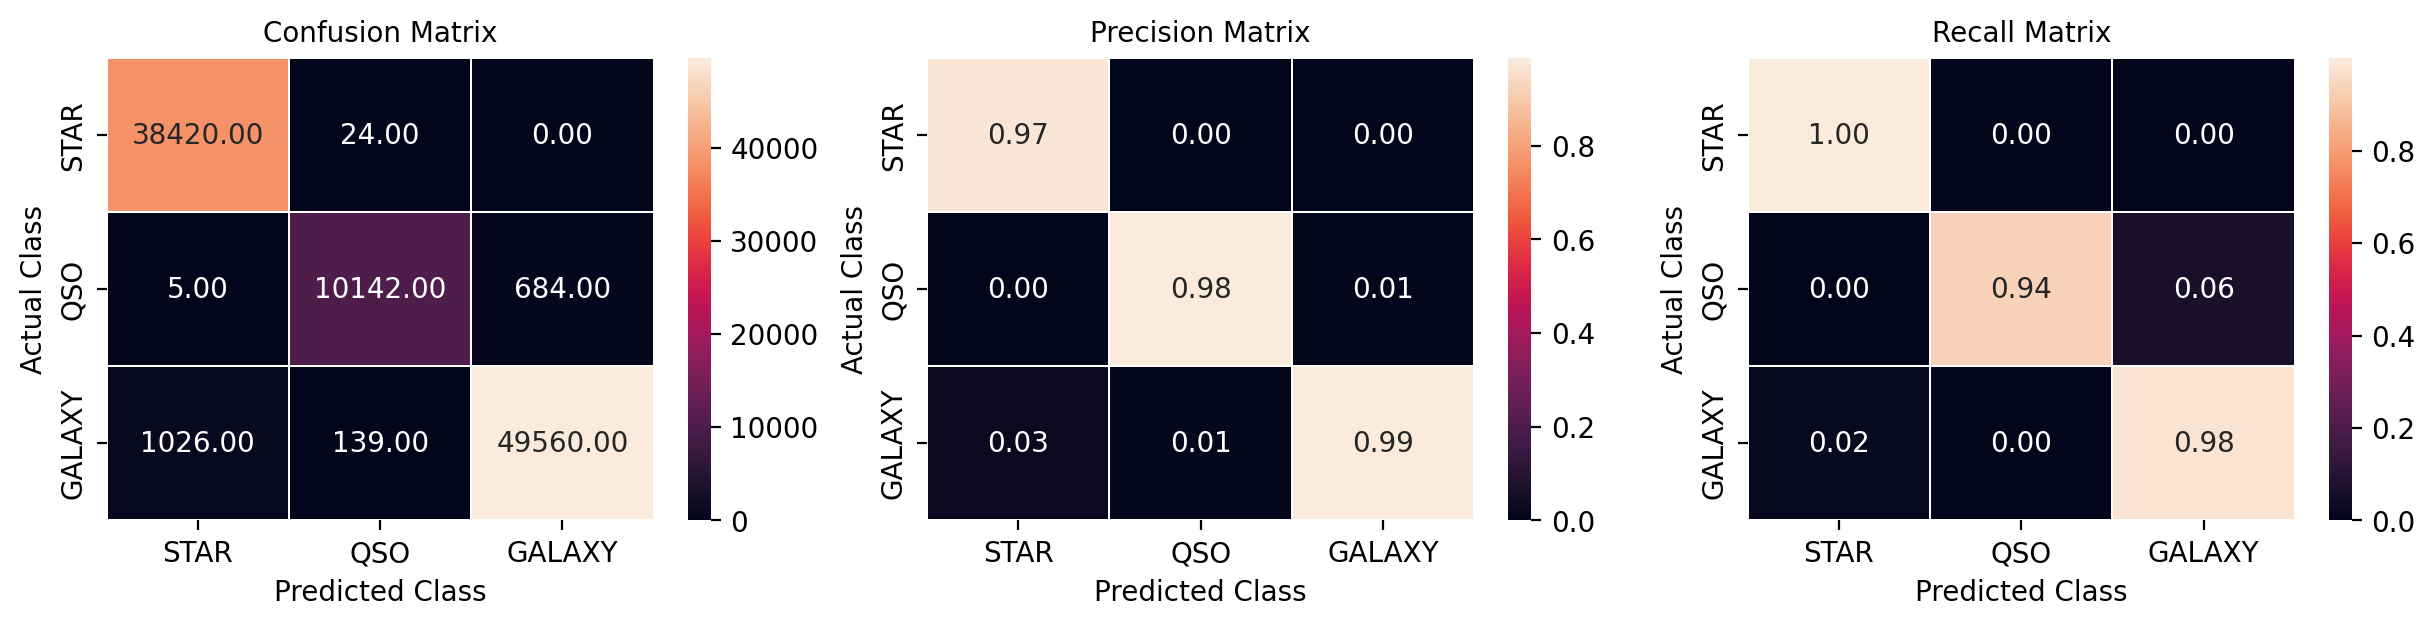

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98     50725
         QSO       0.98      0.94      0.96     10831
        STAR       0.97      1.00      0.99     38444

    accuracy                           0.98    100000
   macro avg       0.98      0.97      0.98    100000
weighted avg       0.98      0.98      0.98    100000

Validation
Logloss: 0.075
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


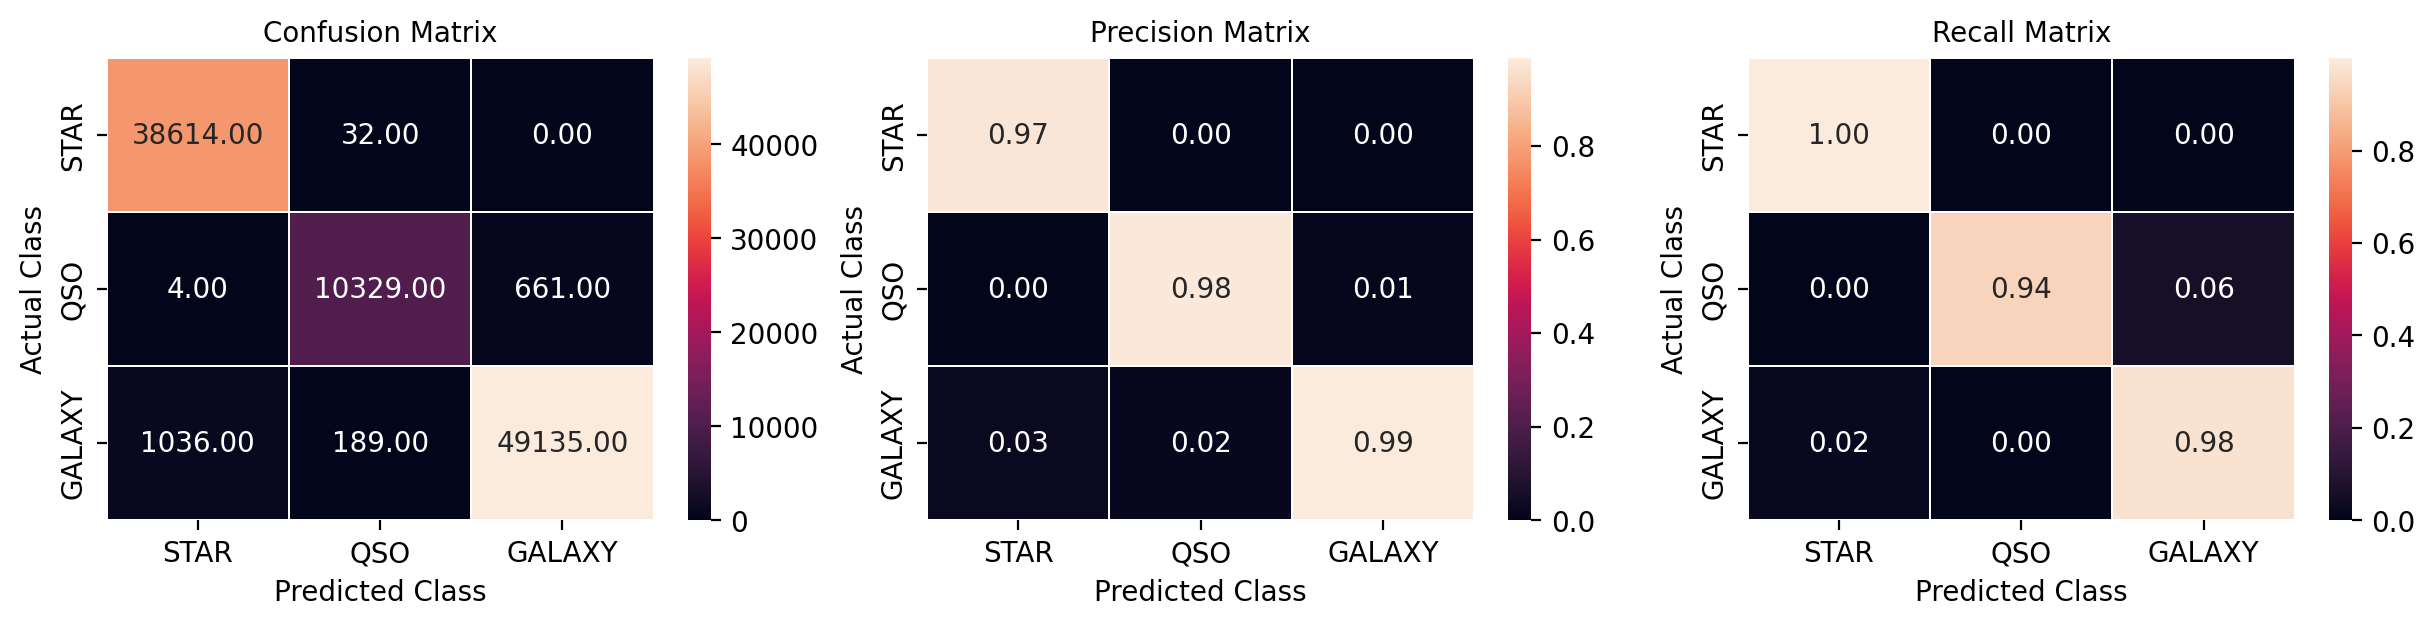

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98     50360
         QSO       0.98      0.94      0.96     10994
        STAR       0.97      1.00      0.99     38646

    accuracy                           0.98    100000
   macro avg       0.98      0.97      0.98    100000
weighted avg       0.98      0.98      0.98    100000



In [33]:
training_loss = reporter(clf=clf, X=X_train, y=y_train, title='Train', labels=labels)
test_loss = reporter(clf=clf, X=X_test, y=y_test, title='Test', labels=labels)
val_loss = reporter(clf=clf, X=X_val, y=y_val, title='Validation', labels=labels)

In [34]:
clf = LogisticRegressionCV(cv=cv, penalty='l2',solver='saga',n_jobs=-1,random_state=random_seed)

In [ ]:
param_grid = {
    'Cs':Integer(10,1000,random_state=random_seed)
    }

ga_clf = GASearchCV(estimator=clf,
                        cv=cv,
                        scoring='accuracy',
                        population_size=10,
                        generations=5,
                        tournament_size=3,
                        elitism=True,
                        crossover_probability=0.5,
                        mutation_probability=0.1,
                        param_grid=param_grid,
                        criteria='max',
                        algorithm='eaMuPlusLambda',
                        n_jobs=-1,
                        verbose=True,
                        keep_top_k=3)
ga_clf.fit(X=X_train,y=y_train)